In [1]:
UNET_TARGET_REPLACE = {"Transformer2DModel"}

TEXT_ENCODER_TARGET_REPLACE = {"CLIPAttention"}

EMBED_FLAG = "<embed>"

In [2]:
import json
import math
from itertools import groupby
from typing import Callable, Dict, List, Optional, Set, Tuple, Type, Union

import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from safetensors.torch import safe_open
    from safetensors.torch import save_file as safe_save

    safetensors_available = True
except ImportError:
    from .safe_open import safe_open
import argparse
import hashlib
import inspect
import itertools
import math
import os
import random
import re
from pathlib import Path
from typing import Optional, List, Literal

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
import wandb

In [3]:
import random
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

from PIL import Image
from torch import zeros_like
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt



In [4]:
class PivotalTuningDatasetCapation(Dataset):
    """
    La classe hérite de Dataset de pytorch qui attend une méthode len et une méthode getitem

    init :
    Construit une liste à partir des images données dans instance_data_root : ["./images/cat1.jpg", "./images/cat2.png", "./images/cat3.jpeg"]
    Construit une liste des titres à partir des titres des images : ["cat1","cat2",cat3]
    Redimensionne les images à la taille size, crop les images pour qu'elles soient carrées, normalise les valeurs de pixels entre [-1,1]
    et transforme l'image en tenseur


    get_item :
    Retourne un dictionnaire example ou example["instance_images"] = l'image transformée en tensor et  example["instance_prompt_ids"] = la liste
    des ids des tokens du prompt qui est le nom que l'on a donné à l'image dans le dossier

    """

    def __init__(
        self,
        instance_data_root,
        tokenizer,
        size=64,
        h_flip=True,
        resize=True,
        blur_amount: int = 70,
        token_map: Optional[dict] = None,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.resize = resize

        instance_data_root = Path(instance_data_root)
        if not instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = []

        #Le résultat est une liste de chemins d'images ["./images/cat1.jpg", "./images/cat2.png", "./images/cat3.jpeg"
        #glob.glob() est nécessaire (ou du moins très pratique) pour construire automatiquement une liste de fichiers
        #correspondant à un motif de nom de fichier, par exemple toutes les images dans un dossier avec certaines extensions
        self.instance_images_path = (
            glob.glob(str(instance_data_root) + "/*.jpg")
            + glob.glob(str(instance_data_root) + "/*.png")
            + glob.glob(str(instance_data_root) + "/*.jpeg")
        )

        #On génère une liste de captions à partir des noms de fichiers
        #Pour `./images/cat1.jpg`, on obtient la caption `"cat1"`.
        self.captions = [
            x.split("/")[-1].split(".")[0] for x in self.instance_images_path
        ]

        assert (
            len(self.instance_images_path) > 0
        ), "No images found in the instance data root."

        self.instance_images_path = sorted(self.instance_images_path)

        self._length = len(self.instance_images_path)

        self.h_flip = h_flip
        #suite de transformations appliquées à une image
        self.image_transforms = transforms.Compose(
            [   #redimensionne l'image à la taille size si resize est vrai
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                #crop l'image pour qu'elle soit carrée
                transforms.CenterCrop(size),
                #convertit l'image en tensor
                transforms.ToTensor(),
                #Normalise les pixels : `x = (x - 0.5) / 0.5`
                #Résultat : valeurs entre `[-1, 1]` au lieu de `[0, 1]`
                #Cette normalisation est **standard dans les modèles de diffusion** (ex : Stable Diffusion) qui attendent des inputs entre -1 et 1.
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.token_map = token_map

    def __len__(self):
        return self._length

    def __getitem__(self, index):

        example = {}

        #on place l'image index dans le dictionnaire example

        instance_image = Image.open(
            self.instance_images_path[index]
        )
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")

        example["instance_images"] = self.image_transforms(instance_image)

        #symétrie horizontale pour ajouter de la diversité au dataset
        if self.h_flip and random.random() > 0.5:
            hflip = transforms.RandomHorizontalFlip(p=1)

            example["instance_images"] = hflip(example["instance_images"])

        #on place la liste d'ids du prompt dans le dictionnaire example

        text = self.captions[index]

        #Si on a une token_map, on remplace tous les tokens cibles dans le texte.
        if self.token_map is not None:
            for token, value in self.token_map.items():
                text = text.replace(token, value)
        print("prompt du get_item %s"% text)

        #tokenize le texte "image1" → ["image", "1"], convertit les tokens en IDs (par ex. [2034, 129]) et retourne ces IDs
        example["instance_prompt_ids"] = self.tokenizer(
            text,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

In [5]:
def get_models(
    pretrained_model_name_or_path,
    revision,
    placeholder_tokens: List[str],
    initializer_tokens: List[str],
    device="cuda:0",
):
    """
    placeholder_tokens = [<tok1>,<tok2>]
    initializer_tokens = [<zeros>,<rand-0.5>]
    placeholder_token_ids = []
    Ajoute les placeholder_tokens au tokenizer
    Ajoute les ids de placeholder_tokens à placeholder_token_ids
    Augmente la taille de text_encoder pour qu'elle corresponde à la nouvelle taile du tokenizer
    Initialise les embeddings des nouveaux tokens en fonction de initializer_tokens
    Renvoie les modèles chargés sur cuda et la liste placeholder_token_ids

    """

    tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=revision,
    )

    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )

    placeholder_token_ids = []

    for token, init_tok in zip(placeholder_tokens, initializer_tokens):
        num_added_tokens = tokenizer.add_tokens(token)
        if num_added_tokens == 0:
            raise ValueError(
                f"The tokenizer already contains the token {token}. Please pass a different"
                " `placeholder_token` that is not already in the tokenizer."
            )

        placeholder_token_id = tokenizer.convert_tokens_to_ids(token)

        placeholder_token_ids.append(placeholder_token_id)

        #On redimensionne le text_encoder car la dimension du vocabulaire s'est agrandie
        text_encoder.resize_token_embeddings(len(tokenizer))
        #La matrice de poids du text_encoder
        token_embeds = text_encoder.get_input_embeddings().weight.data
        #initialisation dépend d'init_tok
        if init_tok.startswith("<rand"):
            # <rand-"sigma">, e.g. <rand-0.5>
            sigma_val = float(re.findall(r"<rand-(.*)>", init_tok)[0])

            token_embeds[placeholder_token_id] = (
                torch.randn_like(token_embeds[0]) * sigma_val
            )
            print(
                f"Initialized {token} with random noise (sigma={sigma_val}), empirically {token_embeds[placeholder_token_id].mean().item():.3f} +- {token_embeds[placeholder_token_id].std().item():.3f}"
            )
            print(f"Norm : {token_embeds[placeholder_token_id].norm():.4f}")

        elif init_tok == "<zero>":
            token_embeds[placeholder_token_id] = torch.zeros_like(token_embeds[0])
        #On copie l'embedding du token choisi pour initialiser notre nouveau token, par exemple un embedding de personnage pourrait être utile pour démarrer l'apprentissage d'un personnage spécifique
        else:
            token_ids = tokenizer.encode(init_tok, add_special_tokens=False)
            # Check if initializer_token is a single token or a sequence of tokens
            if len(token_ids) > 1:
                raise ValueError("The initializer token must be a single token.")

            initializer_token_id = token_ids[0]
            token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        revision=revision,
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="unet",
        revision=revision,
    )

    #les modèles sont par défaut chargés sur le cpu donc il faut explicitement les mettre sur cuda
    return (
        text_encoder.to(device),
        vae.to(device),
        unet.to(device),
        tokenizer,
        placeholder_token_ids,
    )

In [6]:
#On parcourt les dictionnaires example de PivotalTuningDataset avec une boucle for idx ce qui est possible grâce à la fonction getitem
#on créé une liste cached_latents_dataset = [] qui contient les objets example où l'image a été remplacée par un latent
#on utilise la fonction Dataloader pour créer des sous listes de cached_latents_dataset de taille batch_size, et on leur applique la fonction
#collate_fn qui construit un tensor des images et un tensor des captions et renvoie un dictionnaire batch des deux



In [7]:
def text2img_dataloader(
    train_dataset,
    train_batch_size,
    tokenizer,
    vae,
    text_encoder,
):

    """
    On parcourt les dictionnaires example de PivotalTuningDataset avec une boucle for idx ce qui est possible grâce à la fonction getitem
    on créé une liste cached_latents_dataset = [] qui contient les objets example où l'image a été remplacée par un latent
    on utilise la fonction Dataloader pour créer des sous listes de cached_latents_dataset de taille batch_size, et on leur applique la fonction
    collate_fn qui construit un tensor des images et un tensor des captions et renvoie un dictionnaire batch des deux

    """


    #permet de ne pas construire de graphe à partir de la transformation des images en latent car on ne veut pas la modifier
    with torch.no_grad() :
      cached_latents_dataset = []
      #tdqm rajoute la barre de progression
      for idx in tqdm(range(len(train_dataset))):
          batch = train_dataset[idx]
          #batch["instance_images"] : un Tensor image de taille (3, H, W) (format image).
          #unsqueeze(0) : Les modèles comme vae.encode() attendent des batches d’images, même si c’est un seul élément. Donc on ajoute une dimension "batch = 1".
          #to(vae.device) : le vae va faire des opérations sur le tenseur qui doit donc être sur le même device
          #latent_dist.sample() : le vae encode l'image en distribution latente. On échantillonne un latent vector depuis cette distribution.
          latents = vae.encode(batch["instance_images"].unsqueeze(0).to(vae.device)
          ).latent_dist.sample()
          #pas d'explication sur cette valeur dans l'article officiel
          latents = latents * 0.18215
          #on remplace les images par les latents
          batch["instance_images"] = latents.squeeze(0)
          cached_latents_dataset.append(batch)

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        #création d'un tensor (batch_size, C, H, W)
        pixel_values = [example["instance_images"] for example in examples]
        pixel_values = torch.stack(pixel_values)

        #"A dog"	[1547, 21]	[1547, 21, 0, ..., 0] pour former un batch (tensor) de shape (batch_size, sequence_length), toutes les séquences doivent avoir la même longueur. Sinon, torch.stack va planter.
        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }

        return batch

    #on applique collate_fn

    train_dataloader = torch.utils.data.DataLoader(
        cached_latents_dataset,
        batch_size=train_batch_size,
        # le DataLoader lit les données dans un ordre différent à chaque epoch, ce qui est une forme de randomisation très utile pour éviter l’overfitting et améliorer la généralisation.
        #PyTorch crée un RandomSampler : indices aléatoires [2, 0, 3, 1]
        shuffle=True,
        #Puis crée des mini-batches en regroupant les indices : [[2, 0], [3, 1]] si batch_size=2
        collate_fn=collate_fn,
    )
    print(f"Allocated : {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached    : {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print("Suppressin du vae")
    del vae
    torch.cuda.empty_cache()
    print(f"Allocated : {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached    : {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

    return train_dataloader

In [8]:
def loss_step(
    batch,
    unet,
    text_encoder,
    scheduler,
    t_mutliplier=1.0
):
    """
    on créé un tensor noise composé de bruits gaussiens pour chaque latent du batch
    on créé un tensor timesteps composé d'étapes de temps tirées au hasard entre 1 et 1000 pour chaque latent du batch
    on créé un tensor noisy_latents composé des latents auxquels on ajouté le bruit gaussien suivant l'étape de temps conformément à la formule des modèles
    de diffusion
    on créé un tensor encoder_hidden_states composé des embeddings correspondant aux inputs_ids du prompt
    on applique le unet aux tensors noisy_latents, timesteps et encoder_hidden_states
    calcul de la loss entre le résultat du sample et noise

    """
    latents = batch["pixel_values"]

    # pour chaque latent créé un bruit gaussien de même taille
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]

    #on tire bsz (batch_size) valeurs entre 0 et 1000 * 1 = 1000, pour que chaque latent soit bruité à un niveau différent
    timesteps = torch.randint(
        0,
        int(scheduler.config.num_train_timesteps * t_mutliplier),
        (bsz,),
        #torch.rand_like fait hériter le tenseur du device de latents donc on n'a pas besoin de l'expliciter contrairement à ici
        device=latents.device,
    )
    timesteps = timesteps.long()

    # le scheduler utilise la formule avec les alpha_t et les beta_t vue dans le modèle probabiliste de la diffusion pour passer de x0 directement à xt sans passer par les xt-1
    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    latent_model_input = noisy_latents

    encoder_hidden_states = text_encoder(
        batch["input_ids"].to(text_encoder.device)
    )[0]

    model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample

    loss = (
        #moyenne de l'erreur au carré sur chaque pixel
        F.mse_loss(model_pred, noise)
    )

    return loss

In [9]:
"""
Backpropagation

During the forward pass, an operation is only recorded in the backward graph if at least one of its input tensors require grad.
During the backward pass (.backward()), only leaf tensors with requires_grad=True will have gradients accumulated into their .grad fields.

"""

'\nBackpropagation\n\nDuring the forward pass, an operation is only recorded in the backward graph if at least one of its input tensors require grad.\nDuring the backward pass (.backward()), only leaf tensors with requires_grad=True will have gradients accumulated into their .grad fields.\n\n'

In [10]:
"""
no-grad mode

Computations in no-grad mode behave as if none of the inputs require grad.
In other words, computations in no-grad mode are never recorded in the backward graph even if there are inputs that have require_grad=True

Enable no-grad mode when you need to perform operations that should not be recorded by autograd, but you’d still like to use the outputs of
these computations in grad mode later. This context manager makes it convenient to disable gradients for a block of code or function without
having to temporarily set tensors to have requires_grad=False, and then back to True.

For example, no-grad mode might be useful when writing an optimizer: when performing the training update you’d like to update parameters in-place
without the update being recorded by autograd. You also intend to use the updated parameters for computations in grad mode in the next forward pass.

torch.set_grad_enabled(bool) : set_grad_enabled will enable or disable grads based on its argument mode.

"""

'\nno-grad mode\n\nComputations in no-grad mode behave as if none of the inputs require grad.\nIn other words, computations in no-grad mode are never recorded in the backward graph even if there are inputs that have require_grad=True\n\nEnable no-grad mode when you need to perform operations that should not be recorded by autograd, but you’d still like to use the outputs of\nthese computations in grad mode later. This context manager makes it convenient to disable gradients for a block of code or function without\nhaving to temporarily set tensors to have requires_grad=False, and then back to True.\n\nFor example, no-grad mode might be useful when writing an optimizer: when performing the training update you’d like to update parameters in-place\nwithout the update being recorded by autograd. You also intend to use the updated parameters for computations in grad mode in the next forward pass.\n\ntorch.set_grad_enabled(bool) : set_grad_enabled will enable or disable grads based on its ar

In [11]:
"""
You are responsible for calling model.eval() and model.train() if your model relies on modules such as torch.nn.Dropout and torch.nn.BatchNorm2d
that may behave differently depending on training mode, for example, to avoid updating your BatchNorm running statistics on validation data.

It is recommended that you always use model.train() when training and model.eval() when evaluating your model (validation/testing)
even if you aren’t sure your model has training-mode specific behavior, because a module you are using might be updated to behave differently
in training and eval modes.

"""

'\nYou are responsible for calling model.eval() and model.train() if your model relies on modules such as torch.nn.Dropout and torch.nn.BatchNorm2d\nthat may behave differently depending on training mode, for example, to avoid updating your BatchNorm running statistics on validation data.\n\nIt is recommended that you always use model.train() when training and model.eval() when evaluating your model (validation/testing)\neven if you aren’t sure your model has training-mode specific behavior, because a module you are using might be updated to behave differently\nin training and eval modes.\n\n'

In [12]:
def train_inversion(
    unet,
    text_encoder,
    dataloader,
    num_steps: int,
    scheduler,
    index_no_updates,
    optimizer,
    save_steps: int,
    placeholder_token_ids,
    placeholder_tokens,
    save_path: str,
    tokenizer,
    lr_scheduler,
    test_image_path: str
):

    """
    Entraine les embeddings des nouveaux tokens du text_encoder

    """
    index_updates = ~index_no_updates
    print("index_updates %s"%{index_updates})
    ids_updates = []
    for i in range (len(index_updates)) :
      if index_updates[i] :
        ids_updates.append(i)
    ti_loss = []
    ti_grad = []
    ti_embeds_norm = {}
    for i in ids_updates :
      ti_embeds_norm[tokenizer.convert_ids_to_tokens(i)] = []
    progress_bar = tqdm(range(num_steps))
    progress_bar.set_description("Steps")
    global_step = 0

    #.eval() = pas d’éléments stochastiques comme le dropout ou la batchnorm dynamique, les gradients sont quand même calculés
    unet.eval()
    text_encoder.train()

    orig_embeds_params = text_encoder.get_input_embeddings().weight.data.clone()

    for epoch in range(math.ceil(num_steps / len(dataloader))):

        for batch in dataloader:

            #le scheduler est créé avec num_training_steps = num_epochs * len(dataloader)
            #fait passer le lr à l'étape suivante par exemple s'il suit un cosine
            #le LR commence haut, décroît doucement, et approche 0 de manière "cosine"
            #current_lr = lr_scheduler.get_last_lr()[0] pour voir l'évolution
            lr_scheduler.step()

            #on active le calcul de gradient
            loss = (
                loss_step(
                    batch,
                    unet,
                    text_encoder,
                    scheduler,
                )
            )
            #print("loss")
            #print(loss)
            #print(f"Loss id: {id(loss)}")
            loss.backward()
            ti_loss.append(loss.detach().item())

            grads = text_encoder.get_input_embeddings().weight.grad  # Tensor de shape [V, D]
            # 4. Calculer les normes des gradients par vecteur (chaque ligne est un vecteur)
            # Norme L2 par vecteur (par token)
            grad_norms = grads.norm(p=2, dim=1)  # Shape: [V]
            # 5. Moyenne des normes
            mean_grad_norm = grad_norms.mean().item()
            ti_grad.append(mean_grad_norm)
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad() :
                text_encoder.get_input_embeddings().weight[
                    index_no_updates
                ] = orig_embeds_params[index_no_updates]
                for id in ids_updates :
                  ti_embeds_norm[tokenizer.convert_ids_to_tokens(id)].append(text_encoder.get_input_embeddings()
                            .weight[id, :]
                            .norm(dim=-1).item())
            global_step += 1
            progress_bar.update(1)

    return ti_loss, ti_grad, ti_embeds_norm

In [13]:
#création de la liste des placeholder_tokens et des initializer_tokens à partir des chaînes de caractères passées en argument
#création de la liste placeholder_token_ids avec get_models
#création d'une liste index_no_updates de la même taille que tokenizer où tous les ids sauf ceux de placeholder_token_ids sont False
#création d'une liste index_no_updates qui indique les embeddings qu'il ne faut pas entrainer
#on désactive les gradients du vae, de l'unet et du text encoder sauf ceux des embeddings qu'on entraine
#on créé l'optimizer en prenant les paramètres des embeddings du text_encoder en argument, ainsi que le lr_scheduler
#on applique train_inversion

In [14]:
def prepare_dataset(
    instance_data_dir: str,
    pretrained_model_name_or_path: str,
    output_dir: str,
    revision: Optional[str] = None,
    placeholder_tokens: str = "",
    initializer_tokens: Optional[str] = None,
    seed: int = 42,
    resolution: int = 64,
    train_batch_size: int = 1,
    sample_batch_size: int = 1,
    max_train_steps_tuning: int = 1000,
    max_train_steps_ti: int = 1000,
    save_steps: int = 100,
    lora_rank: int = 4,
    lora_unet_target_modules={"Transformer2DModel"},
    lora_clip_target_modules={"CLIPAttention"},
    lora_dropout_p: float = 0.0,
    lora_scale: float = 1.0,
    use_extended_lora: bool = False,
    learning_rate_unet: float = 1e-4,
    learning_rate_text: float = 1e-5,
    learning_rate_ti: float = 5e-4,
    lr_scheduler: str = "linear",
    lr_warmup_steps: int = 0,
    lr_scheduler_lora: str = "linear",
    lr_warmup_steps_lora: int = 0,
    device="cuda:0",
    out_name: str = "final_lora",
    token_map: Optional[dict] = None,
):
    torch.manual_seed(seed)

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
    #construit la liste des placeholder_tokens et des initializer_tokens à partir des chaînes de caractères passées en argument
    if len(placeholder_tokens) == 0:
        placeholder_tokens = []
        print("PTI : Placeholder Tokens not given, using null token")
    else:
        placeholder_tokens = placeholder_tokens.split("|")

        assert (
            sorted(placeholder_tokens) == placeholder_tokens
        ), f"Placeholder tokens should be sorted. Use something like {'|'.join(sorted(placeholder_tokens))}'"

    if initializer_tokens is None:
        print("PTI : Initializer Tokens not given, doing random inits")
        initializer_tokens = ["<rand-0.017>"] * len(placeholder_tokens)
    else:
        initializer_tokens = initializer_tokens.split("|")

    assert len(initializer_tokens) == len(
        placeholder_tokens
    ), "Unequal Initializer token for Placeholder tokens."


    print("PTI : Placeholder Tokens", placeholder_tokens)
    print("PTI : Initializer Tokens", initializer_tokens)

    # get the models
    text_encoder, vae, unet, tokenizer, placeholder_token_ids = get_models(
        pretrained_model_name_or_path,
        revision,
        placeholder_tokens,
        initializer_tokens,
        device=device,
    )

    noise_scheduler = DDPMScheduler.from_config(
        pretrained_model_name_or_path, subfolder="scheduler"
    )

    train_dataset = PivotalTuningDatasetCapation(
        instance_data_root=instance_data_dir,
        tokenizer=tokenizer,
        size=resolution,
        token_map=token_map
    )

    train_dataloader = text2img_dataloader(
        train_dataset,
        train_batch_size,
        tokenizer,
        vae,
        text_encoder,
    )

    #liste de même taille que tokenizer où tous les éléments valent True
    index_no_updates = torch.arange(len(tokenizer)) != -1

    #on met False sur les éléments à update
    for tok_id in placeholder_token_ids:
        index_no_updates[tok_id] = False

    return placeholder_tokens, initializer_tokens, placeholder_token_ids, text_encoder, vae, unet, tokenizer, noise_scheduler,  index_no_updates, train_dataloader



In [15]:
def train(
    placeholder_tokens,
    initializer_tokens,
    placeholder_token_ids,
    text_encoder,
    unet,
    tokenizer,
    noise_scheduler,
    index_no_updates,
    train_dataloader,
    instance_data_dir: str,
    pretrained_model_name_or_path: str,
    output_dir: str,
    revision: Optional[str] = None,
    seed: int = 42,
    resolution: int = 64,
    train_batch_size: int = 1,
    sample_batch_size: int = 1,
    max_train_steps_tuning: int = 1000,
    max_train_steps_ti: int = 1000,
    save_steps: int = 100,
    lora_rank: int = 4,
    lora_unet_target_modules={"Transformer2DModel"},
    lora_clip_target_modules={"CLIPAttention"},
    lora_dropout_p: float = 0.0,
    lora_scale: float = 1.0,
    learning_rate_unet: float = 1e-4,
    learning_rate_text: float = 1e-5,
    learning_rate_ti: float = 5e-4,
    lr_scheduler: str = "linear",
    lr_warmup_steps: int = 0,
    lr_scheduler_lora: str = "linear",
    lr_warmup_steps_lora: int = 0,
    weight_decay_ti: float = 0.00,
    weight_decay_lora: float = 0.001,
    device="cuda:0",
    out_name: str = "final_lora",
):

    """
    Construit le scheduler et l'optimizer pour faire le text_inversion, puis exécute train_inversion.
    Injecte les loras dans les modèles prévus.
    Construit le scheduler et l'optimizer pour entrainé les loras, puis exécute perform_tuning.

    """
    unet_lr = learning_rate_unet
    text_encoder_lr = learning_rate_text
    ti_lr = learning_rate_ti

    # STEP 1 : Perform Inversion

    index_updates = ~index_no_updates

    unet.requires_grad_(False)
    text_encoder.requires_grad_(True)


    #text_encoder = CLIPTextModel
    #text_encoder à un attribut text_model qui est un CLIPTextTransformer
    #CLIPTextTransformer a des attributs embeddings = CLIPTextEmbeddings(config), encoder = CLIPEncoder(config) et final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)
    #CLIPTextEmbeddings a deux attributs token_embedding et position_embedding qui sont des nn.Embedding
    #get_input_embeddings renvoie self.text_model.embeddings.token_embedding
    #https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L48
    #on freeze tout sauf les embeddings des tokens
    params_to_freeze = itertools.chain(
        text_encoder.text_model.encoder.parameters(),
        text_encoder.text_model.final_layer_norm.parameters(),
        text_encoder.text_model.embeddings.position_embedding.parameters(),
    )
    for param in params_to_freeze:
        param.requires_grad = False

    ti_optimizer = optim.AdamW(
        #tous les embeddings sont passés à l'optimizer mais seuls ceux dont a calculé le gradient donc les nouveaux ids seront mis à jour
        text_encoder.get_input_embeddings().parameters(),
        lr=ti_lr,
        betas=(0.9, 0.999),
        eps=1e-08
    )

    #https://huggingface.co/docs/transformers/main_classes/optimizer_schedules
    #applique les schedulers de cette page comme get_cosine_schedule_with_warmup
    #le warm-up est une phase pendant laquelle lr augmente linéairement de 0 au lr choisi dans l'optimizer
    lr_scheduler = get_scheduler(
        lr_scheduler,
        optimizer=ti_optimizer,
        num_warmup_steps=lr_warmup_steps,
        num_training_steps=max_train_steps_ti,
    )

    ti_loss,ti_grad,ti_weights = train_inversion(
        unet,
        text_encoder,
        train_dataloader,
        max_train_steps_ti,
        scheduler=noise_scheduler,
        index_no_updates=index_no_updates,
        optimizer=ti_optimizer,
        lr_scheduler=lr_scheduler,
        save_steps=save_steps,
        placeholder_tokens=placeholder_tokens,
        placeholder_token_ids=placeholder_token_ids,
        save_path=output_dir,
        test_image_path=instance_data_dir,
        tokenizer=tokenizer)

    del ti_optimizer


    # Next perform Tuning with LoRA:

    tracked_lora_paths = {"UNet2DConditionModel":[],"CLIPTextModel":[]}
    tracked_lora_weights = {}
    tracked_lora_grads = {}

    unet.requires_grad_(False)
    text_encoder.requires_grad_(False)

    unet_lora_params, _ = inject_trainable_lora_extended(
        unet, r=lora_rank, target_replace_module=lora_unet_target_modules,tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads
    )
    print(f"PTI : has {len(unet_lora_params)} lora")

    if len(unet_lora_params) == 0:
        unet_lora_params = set_lora_grad(unet, r=lora_rank, target_replace_module=lora_unet_target_modules,tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads)

    print("new len unet_lora_params%s"% len(unet_lora_params))
    #aplatit la liste   pour donner à l'optimizer une seule séquence de paramètres
    params_to_optimize = [
        {"params": itertools.chain(*unet_lora_params), "lr": unet_lr},
    ]

    text_encoder_lora_params, _ = inject_trainable_lora_extended(
        text_encoder,
        r=lora_rank,
        target_replace_module=lora_clip_target_modules,
        tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads
    )

    if len(text_encoder_lora_params) == 0:
        text_encoder_lora_params = set_lora_grad(text_encoder, r=lora_rank, target_replace_module=lora_clip_target_modules,tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads)

    params_to_optimize += [
        {
            "params": itertools.chain(*text_encoder_lora_params),
            "lr": text_encoder_lr,
        }
    ]
    lora_optimizers = optim.AdamW(params_to_optimize, weight_decay=weight_decay_lora)

    lr_scheduler_lora = get_scheduler(
        lr_scheduler_lora,
        optimizer=lora_optimizers,
        num_warmup_steps=lr_warmup_steps_lora,
        num_training_steps=max_train_steps_tuning,
    )

    tuning_loss = perform_tuning(
        unet,
        text_encoder,
        train_dataloader,
        max_train_steps_tuning,
        scheduler=noise_scheduler,
        optimizer=lora_optimizers,
        save_steps=save_steps,
        placeholder_tokens=placeholder_tokens,
        placeholder_token_ids=placeholder_token_ids,
        save_path=output_dir,
        lr_scheduler_lora=lr_scheduler_lora,
        lora_unet_target_modules=lora_unet_target_modules,
        lora_clip_target_modules=lora_clip_target_modules,
        tokenizer=tokenizer,
        out_name=out_name,
        test_image_path=instance_data_dir,
        tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads
    )

    return tuning_loss, ti_loss,ti_grad,ti_weights,tracked_lora_grads,tracked_lora_weights,tracked_lora_paths

In [16]:
def perform_tuning(
    unet,
    text_encoder,
    dataloader,
    num_steps,
    scheduler,
    optimizer,
    save_steps: int,
    placeholder_token_ids,
    placeholder_tokens,
    save_path,
    lr_scheduler_lora,
    lora_unet_target_modules,
    lora_clip_target_modules,
    out_name: str,
    tokenizer,
    test_image_path: str,
    tracked_lora_paths,tracked_lora_weights,tracked_lora_grads
):

    progress_bar = tqdm(range(num_steps))
    progress_bar.set_description("Steps")
    global_step = 0

    tuning_loss = []
    tuning_grad = []


    unet.train()
    text_encoder.train()

    with torch.set_grad_enabled(True) :

      for epoch in range(math.ceil(num_steps / len(dataloader))):
          for i,batch in enumerate (dataloader):
              if epoch == 0 and i == 0 :
                print("Verification que le token cible a bien été remplacé %s" % tokenizer.convert_ids_to_tokens(batch["input_ids"][0]))
              # lr_scheduler_lora.step()
              # print("lr_scheduler_lora%s"%{lr_scheduler_lora.get_last_lr()[0]})

              loss = loss_step(
                  batch,
                  unet,
                  text_encoder,
                  scheduler,
                  t_mutliplier=0.8,
              )

              loss.backward()
              tuning_loss.append(loss.detach().item())
              # for i, group in enumerate(optimizer.param_groups):
              #     print("group %s %s" % (i,group))
              # group = optimizer.param_groups[0]
              # print("group %s" % group)
              # param = group["params"][0]
              # print("param data %s"% param.data)
              # print("param grad %s"% param.grad)
              # print("learning rate %s"% group['lr'])
              add_tracked_lora_weights(unet, tracked_lora_paths,tracked_lora_weights,tracked_lora_grads)
              add_tracked_lora_weights(text_encoder, tracked_lora_paths,tracked_lora_weights,tracked_lora_grads)
              optimizer.step()
              optimizer.zero_grad()
              module = unet
              # path = "down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q"
              # for key in path.split("."):
              #     module = getattr(module, key)
              # with torch.no_grad() :
              #   if hasattr(module, "lora_up") and hasattr(module, "lora_down"):
              #       up = module.lora_up.weight
              #       down = module.lora_down.weight
              #       delta = (up @ down).flatten().abs().mean().item()
              #       print ("delta %s"%{delta})
              progress_bar.update(1)
              logs = {
                  "loss": loss.detach().item(),
                  "lr": lr_scheduler_lora.get_last_lr()[0],
              }
              progress_bar.set_postfix(**logs)

              global_step += 1

    save_all(
        unet,
        text_encoder,
        placeholder_token_ids=placeholder_token_ids,
        placeholder_tokens=placeholder_tokens,
        save_path=os.path.join(save_path, f"{out_name}.safetensors"),
        target_replace_module_text=lora_clip_target_modules,
        target_replace_module_unet=lora_unet_target_modules,
    )
    return tuning_loss

In [17]:
"""
Roadmap pour sauvegarder les loras et les embeddings

1°) extract_lora_as_tensor :
    extraction des poids des loras up et down dans une liste

2°) save_safeloras_with_embeds :
    construction d'un safetensor avec un dictionnaire weight des poids des loras et des embeddings en utilisant extract_lora_as_tensor
    et un dictionnaire metadata contenant des informations supplémentaires notamment le rang de chaque lora
3°) save_all :
    construit 2 dictionnaires modelmaps et embeds à passer en arguments à save_safeloras_with_embeds
"""


"\nRoadmap pour sauvegarder les loras et les embeddings\n\n1°) extract_lora_as_tensor :\n    extraction des poids des loras up et down dans une liste\n\n2°) save_safeloras_with_embeds :\n    construction d'un safetensor avec un dictionnaire weight des poids des loras et des embeddings en utilisant extract_lora_as_tensor\n    et un dictionnaire metadata contenant des informations supplémentaires notamment le rang de chaque lora\n3°) save_all :\n    construit 2 dictionnaires modelmaps et embeds à passer en arguments à save_safeloras_with_embeds\n"

In [18]:
def extract_lora_as_tensor(
    model, target_replace_module, as_fp16=True
):

    """
    Renvoie une liste loras contenant des tuples (up,down) de tous les loras qu'on a injecté dans model aux target_replace_module

    Paramètres:
        model (`nn.Module`):
            le modèle unet ou text_encoder
        target_replace_module ('set[str]') :
            les modules (Transformer2DModel,CLIPAttention) où on a placé les lora linear et conv

    Sortie :
        loras : liste des tuples (up,down) des poids de chaque lora

    """

    loras = []

    for _m, _n, _child_module in _find_modules(
        model,
        target_replace_module,
        search_class=[LoraInjectedLinear, LoraInjectedConv2d],
    ):
        #realize_as_lora renvoie les poids scale*up,down du lora
        up, down = _child_module.realize_as_lora()
        if as_fp16:
            up = up.to(torch.float16)
            down = down.to(torch.float16)

        loras.append((up, down))

    if len(loras) == 0:
        raise ValueError("No lora injected.")

    return loras

In [19]:
def save_safeloras_with_embeds(
    modelmap: Dict[str, Tuple[nn.Module, Set[str]]] = {},
    embeds: Dict[str, torch.Tensor] = {},
    outpath="./lora.safetensors",
):
    """
    Renvoie un tensor composé de :
        un dictionnaire weights avec les poids de tous les loras injectés ainsi que ceux des embeddings pour le texte
        un dictionnaire metadata avec des informations supplémentaires


    Paramètres:
        modelmap ('Dict[str, Tuple[nn.Module, Set[str]]]') :
            dictionnaire avec le nom du modèle, le modèle et les modules cibles ex: "unet",(unet,"CrossAttention,...")
        embeds ('Dict[str, torch.Tensor]') :
            dictionnaire avec l'id de l'embedding et le tensor correspondant pour les nouveaux tokens
        outpath ('String') :
            le chemin de sauvegarde
    Sortie :
        safetensor :
            un dictionnaire weights avec le poids de tous les loras, et le poids de tous les embeddings
            ex : "unet:1:up" pour les poids ups du premier lora de l'unet
            ex : "<tok1>" pour le poids de l'embedding du token 1
            un dictionnaire metadata avec des informations supplémentaires
            ex : "unet:1:rank" pour le rang du premier lora de l'unet
    """

    weights = {}
    metadata = {}

    for name, (model, target_replace_module) in modelmap.items():
        metadata[name] = json.dumps(list(target_replace_module))

        for i, (_up, _down) in enumerate(
            extract_lora_as_tensor(model, target_replace_module)
        ):
            rank = _down.shape[0]

            metadata[f"{name}:{i}:rank"] = str(rank)
            weights[f"{name}:{i}:up"] = _up
            weights[f"{name}:{i}:down"] = _down

    for token, tensor in embeds.items():
        metadata[token] = EMBED_FLAG
        weights[token] = tensor

    print(f"Saving weights to {outpath}")
    safe_save(weights, outpath, metadata)

In [20]:
# @title
def save_all(
    unet,
    text_encoder,
    save_path,
    placeholder_token_ids=None,
    placeholder_tokens=None,
    save_lora=True,
    save_ti=True,
    target_replace_module_text=TEXT_ENCODER_TARGET_REPLACE,
    target_replace_module_unet=UNET_TARGET_REPLACE,
    safe_form=True,
):
    """
    Construit les dictionnaires modelmaps et embeds à passer en arguments à save_safeloras_with_embeds

    """

    loras = {}
    embeds = {}

    if save_lora:

        loras["unet"] = (unet, target_replace_module_unet)
        loras["text_encoder"] = (text_encoder, target_replace_module_text)

    if save_ti:
        for tok, tok_id in zip(placeholder_tokens, placeholder_token_ids):
            learned_embeds = text_encoder.get_input_embeddings().weight[tok_id]
            print(
                f"Current Learned Embeddings for {tok}:, id {tok_id} ",
                learned_embeds[:4],
            )
            embeds[tok] = learned_embeds.detach().cpu()

    save_safeloras_with_embeds(loras, embeds, save_path)

In [21]:
"""
Roadmap pour charger les loras à partir du safetensor

1°) parse_safeloras :
    Reconstruit un dictionnaire loras de poids et de rangs utilisable à partir du safetensor contenant les dictionnaires weights et metadata.

2°) apply_lora_on_model :
    Ajoute le poids des loras de la liste loras à tous les modules du modèle

3°) apply_lora_from_safetensor :
    construit le dictionnaire loras à partir du safetensor avec parse_safeloras, applique ce dictionnaire à l'unet et au text_encoder avec
    apply_lora_on_model
"""

"\nRoadmap pour charger les loras à partir du safetensor\n\n1°) parse_safeloras :\n    Reconstruit un dictionnaire loras de poids et de rangs utilisable à partir du safetensor contenant les dictionnaires weights et metadata.\n\n2°) apply_lora_on_model :\n    Ajoute le poids des loras de la liste loras à tous les modules du modèle\n\n3°) apply_lora_from_safetensor :\n    construit le dictionnaire loras à partir du safetensor avec parse_safeloras, applique ce dictionnaire à l'unet et au text_encoder avec\n    apply_lora_on_model\n"

In [22]:
def parse_safeloras(
    safeloras,
) -> Dict[str, Tuple[List[nn.parameter.Parameter], List[int], List[str]]]:
    """
    Reconstruit un dictionnaire loras de poids et de rangs utilisable
    à partir du safetensor contenant les dictionnaires weights et metadata.
    Le dictionnaire loras est tel que :
    - lora[model] où model vaut "unet" ou "text_encoder", est un tuple (weights,ranks,target)
    - weights est la liste des poids ups et down de tous les loras du model
    - ranks les rangs des loras
    - target les modules ciblés

    """
    loras = {}
    #safeloras.metadata() récupère le dictionnaire metadate et safeloras.keys() récupère les clés du dictionnaire weights uniquement
    metadata = safeloras.metadata()
    #donne le modèle de la clé ex : "unet:1:up" -> "unet"
    get_name = lambda k: k.split(":")[0]

    keys = list(safeloras.keys())
    #le tri se fait sur le modèle : unet, text_encoder ou les tokens comme <tok1>,<tok2>. Ici on a ajouté toutes les clés unet
    #puis toutes les clés text_encoder dans extract_lora_as_tensor donc ce tri n'est pas forcément utile
    keys.sort(key=get_name)

    for name, module_keys in groupby(keys, get_name):
        info = metadata.get(name)

        if not info:
            raise ValueError(
                f"Tensor {name} has no metadata - is this a Lora safetensor?"
            )

        # Skip Textual Inversion embeds
        if info == EMBED_FLAG:
            continue

        # Handle Loras
        # Extract the targets
        target = json.loads(info)

        # Build the result lists - Python needs us to preallocate lists to insert into them
        module_keys = list(module_keys)
        ranks = [4] * (len(module_keys) // 2)
        weights = [None] * len(module_keys)

        for key in module_keys:
            # Split the model name and index out of the key
            _, idx, direction = key.split(":")
            idx = int(idx)

            # Add the rank
            ranks[idx] = int(metadata[f"{name}:{idx}:rank"])

            # Insert the weight into the list
            idx = idx * 2 + (1 if direction == "down" else 0)
            weights[idx] = nn.parameter.Parameter(safeloras.get_tensor(key))

        loras[name] = (weights, ranks, target)

    return loras

In [23]:
def apply_lora_on_model(
    model,
    loras,
    target_replace_module,
    r: Union[int, List[int]] = 4,
):
    """
    Ajoute le poids des loras de la liste loras à tous les modules du modèle

    """
    for _module, name, _child_module in _find_modules(
        model,
        target_replace_module,
        search_class=[nn.Linear, nn.Conv2d,],
        alpha=1.0
    ):

        if (_child_module.__class__ == nn.Linear) :
            #La matrice de poids up ou down doit être de dimension 2 pour un linear
            if len(loras[0].shape) != 2:
                continue
            up_weight = loras.pop(0)
            down_weight = loras.pop(0)
            delta = alpha*(up_weight @ down_weight)
            _child_module.weight += delta.type(_child_module.weight.dtype).to(_child_module.weight.device)

        elif (_child_module.__class__ == nn.Conv2d):
            #La matrice de poids up ou down doit être de dimension 4 pour un conv2d (out_channels, in_channels, kernel_height, kernel_width)
            #on a un filtre différent pour chaque duo out_channel,in_channel
            if len(loras[0].shape) != 4:
                continue
            up_weight = loras.pop(0)
            down_weight = loras.pop(0)
            delta = alpha*(up_weight.flatten(start_dim=1) @ down_weight.flatten(start_dim=1)).reshape(_child_module.weight.data.shape)
            _child_module.weight += delta.type(_child_module.weight.dtype).to(_child_module.weight.device)

In [24]:
def apply_lora_from_safetensor(pipe, safeloras):
    """
    Applique tous les loras du safetensor à l'unet et au text_encoder

    """
    loras = parse_safeloras(safeloras)

    for name, (lora, ranks, target) in loras.items():
        model = getattr(models, name, None)

        if not model:
            print(f"No model provided for {name}, contained in Lora")
            continue

        apply_lora_on_model(model, lora, target, ranks)

In [25]:
"""
Roadmap pour charger les embeddings à partir du safetensor

1°) parse_safeloras_embeds :
    Reconstruit un dictionnaire embeds d'embeddings utilisable à partir du safetensor contenant les dictionnaires weights et metadata.

2°) apply_learned_embed_in_clip :
    Utilise le dictionnaire embeds des nouveaux tokens pour mettre a jour leur embedding
"""

"\nRoadmap pour charger les embeddings à partir du safetensor\n\n1°) parse_safeloras_embeds :\n    Reconstruit un dictionnaire embeds d'embeddings utilisable à partir du safetensor contenant les dictionnaires weights et metadata.\n\n2°) apply_learned_embed_in_clip :\n    Utilise le dictionnaire embeds des nouveaux tokens pour mettre a jour leur embedding\n"

In [26]:
def parse_safeloras_embeds(
    safeloras,
) -> Dict[str, torch.Tensor]:
    """
    Reconstruit un dictionnaire embeds d'embeddings utilisable
    à partir du safetensor avec les dictionnaires weights et metadata.
    Le dictionnaire embeds est tel que :
    - embeds[token] = embedding du token

    """
    embeds = {}
    metadata = safeloras.metadata()

    for key in safeloras.keys():
        # Only handle Textual Inversion embeds
        meta = metadata.get(key)
        if not meta or meta != EMBED_FLAG:
            continue

        embeds[key] = safeloras.get_tensor(key)

    return embeds

In [27]:
def apply_learned_embed_in_clip(
    learned_embeds,
    text_encoder,
    tokenizer,
    token: Optional[Union[str, List[str]]] = None,
    idempotent=False,
):

    """
    Rajoute les tokens qui sont les keys de learned_embeds dans le tokenizer, crée leur id et ajoute l'embedding au text_encoder.

    Paramètres :
        idempotent :
            Si le token existe déjà dans le tokenizer on va essayer de l'ajouter sous une autre forme ex :
            "mytoken", "mytoke-1>", puis "mytoke-2>"

    """
    if isinstance(token, str):
        trained_tokens = [token]
    elif isinstance(token, list):
        assert len(learned_embeds.keys()) == len(
            token
        ), "The number of tokens and the number of embeds should be the same"
        trained_tokens = token
    else:
        trained_tokens = list(learned_embeds.keys())

    for token in trained_tokens:
        print(token)
        embeds = learned_embeds[token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype
        num_added_tokens = tokenizer.add_tokens(token)

        i = 1
        if not idempotent:
            while num_added_tokens == 0:
                print(f"The tokenizer already contains the token {token}.")
                token = f"{token[:-1]}-{i}>"
                print(f"Attempting to add the token {token}.")
                num_added_tokens = tokenizer.add_tokens(token)
                i += 1
        elif num_added_tokens == 0 and idempotent:
            print(f"The tokenizer already contains the token {token}.")
            print(f"Replacing {token} embedding.")

        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))

        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
    return token

In [28]:
def patch_pipe(
    pipe,
    maybe_unet_path,
    token: Optional[str] = None,
    r: int = 4,
    patch_unet=True,
    patch_text=True,
    patch_ti=True,
    idempotent_token=True,
    unet_target_replace_module=UNET_TARGET_REPLACE,
    text_target_replace_module=TEXT_ENCODER_TARGET_REPLACE,
):

    """
    Applique les loras à l'unet et au text_encoder, ainsi que les embeddings des nouveaux token au tokenizer.

    Paramètres :
        idempotent :
            Si le token existe déjà dans le tokenizer on va essayer de l'ajouter sous une autre forme ex :
            "mytoken", "mytoke-1>", puis "mytoke-2>"

    """

    #framework="pt"	on veut accéder aux tensors au format PyTorch (torch.Tensor)
    safeloras = safe_open(maybe_unet_path, framework="pt", device="cpu")
    apply_lora_from_tensor(pipe, safeloras)
    tok_dict = parse_safeloras_embeds(safeloras)
    if patch_ti:
        apply_learned_embed_in_clip(
            tok_dict,
            pipe.text_encoder,
            pipe.tokenizer,
            token=token,
            idempotent=idempotent_token,
        )
    return tok_dict

In [29]:
class LoraInjectedLinear(nn.Module):
    def __init__(
        self, in_features, out_features, bias=False, r=4, dropout_p=0.1, scale=1.0
    ):
        """
        Module constitué d'un module linéaire avec in et out features ainsi que d'un lora.
        set_selector_from_diag permet de placer une matrice diagonale entre le lora down et le lora up.
        """
        super().__init__()

        if r > min(in_features, out_features):
            raise ValueError(
                f"LoRA rank {r} must be less or equal than {min(in_features, out_features)}"
            )
        self.r = r
        self.linear = nn.Linear(in_features, out_features, bias)
        self.lora_down = nn.Linear(in_features, r, bias=False)
        self.dropout = nn.Dropout(dropout_p)
        self.lora_up = nn.Linear(r, out_features, bias=False)
        self.scale = scale
        self.selector = nn.Identity()

        #initialisation des paramètres avec une loi normale de moyenne 0 et d'écart-type 1/r
        nn.init.normal_(self.lora_down.weight, std=1 / r)
        nn.init.zeros_(self.lora_up.weight)

        # Freeze all params by default
        for param in self.parameters():
            param.requires_grad = False

        # Unfreeze only LoRA parameters
        self.lora_up.weight.requires_grad = True
        self.lora_down.weight.requires_grad = True


    def forward(self, input):
        return (
            self.linear(input)
            #drop randomly zeroes some of the elements of the input tensor with probability p during training
            + self.dropout(self.lora_up(self.selector(self.lora_down(input))))
            * self.scale
        )

    def realize_as_lora(self):
        return self.lora_up.weight.data * self.scale, self.lora_down.weight.data

    def set_selector_from_diag(self, diag: torch.Tensor):
        # diag is a 1D tensor of size (r,)
        assert diag.shape == (self.r,)
        self.selector = nn.Linear(self.r, self.r, bias=False)
        self.selector.weight.data = torch.diag(diag)
        self.selector.weight.data = self.selector.weight.data.to(
            self.lora_up.weight.device
        ).to(self.lora_up.weight.dtype)

In [30]:
class LoraInjectedConv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups: int = 1,
        bias: bool = True,
        r: int = 4,
        dropout_p: float = 0.1,
        scale: float = 1.0,
    ):
        """
        Module constitué d'un module conv2d avec in et out features ainsi que d'un lora.
        Ici la matrice diagonale est une convolution 1d et pas un linear car l'input est en 3d avec les plusieurs channels.
        """
        super().__init__()
        if r > min(in_channels, out_channels):
            raise ValueError(
                f"LoRA rank {r} must be less or equal than {min(in_channels, out_channels)}"
            )
        self.r = r
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )

        self.lora_down = nn.Conv2d(
            in_channels=in_channels,
            out_channels=r,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )
        self.dropout = nn.Dropout(dropout_p)
        self.lora_up = nn.Conv2d(
            in_channels=r,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.selector = nn.Identity()
        self.scale = scale

        nn.init.normal_(self.lora_down.weight, std=1 / r)
        nn.init.zeros_(self.lora_up.weight)

        # Freeze all params by default
        for param in self.parameters():
            param.requires_grad = False

        # Unfreeze only LoRA parameters
        self.lora_up.weight.requires_grad = True
        self.lora_down.weight.requires_grad = True

    def forward(self, input):
        return (
            self.conv(input)
            + self.dropout(self.lora_up(self.selector(self.lora_down(input))))
            * self.scale
        )

    def realize_as_lora(self):
        return self.lora_up.weight.data * self.scale, self.lora_down.weight.data

    def set_selector_from_diag(self, diag: torch.Tensor):
        # diag is a 1D tensor of size (r,)
        assert diag.shape == (self.r,)
        self.selector = nn.Conv2d(
            in_channels=self.r,
            out_channels=self.r,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.selector.weight.data = torch.diag(diag)

        # same device + dtype as lora_up
        self.selector.weight.data = self.selector.weight.data.to(
            self.lora_up.weight.device
        ).to(self.lora_up.weight.dtype)

In [31]:
def _find_children(
    model,
    search_class: List[Type[nn.Module]] = [nn.Linear],
):
    """
    # récupère tous les modules dont la classe est dans la liste [nn.Linear,nn.Conv2d] donnée en argument, ainsi que leur nom et leur parent
    """
    # For each target find every linear_class module that isn't a child of a LoraInjectedLinear
    for parent in model.modules():
        for name, module in parent.named_children():
            if any([isinstance(module, _class) for _class in search_class]):
                yield parent, name, module

In [32]:
#model.modules() renvoie tous les enfants directs et indirects de model

#Les modules récupérés par .modules() consiste en le module seul, il faut utiliser fullname si on veut retrouver leur parent
#model.encoder.layer.2.attention.query = nn.Linear(...)
#for fullname, module in model.named_modules():
#fullname = "encoder.layer.2.attention.query" et module = nn.Linear(...)


In [33]:
#on récupère tous les modules ancestor dont la classe figure dans le set ancestor_class
#on récupère tous les enfants directs ou indirects des modules ancestor, dont la classe est dans la liste search_class [nn.Linear,nn.Conv2d]
#et dont le parent direct n'est pas dans la liste des classes à exclure
#dans la boucle on a exactement le nom complet du parent au module fullname = ancestor.encoder.layer.2.attention.linear, et le module nn.Linear
#on retourne le nom complet du parent ancestor.encoder.layer.2.attention, le nom du module linear, et le module nn.Linear
#on peut donc accéder au module depuis ancestor, mais pas depuis model car on n'a pas le chemin de model à ancestor

#ajout
#pour chaque module modifié, on affiche le chemin de model a ancestor et le chemin de ancestor au module

In [34]:
def _find_modules_v2(
    model,
    ancestor_class: Optional[Set[str]] = None,
    search_class: List[Type[nn.Module]] = [nn.Linear],
    exclude_children_of: Optional[List[Type[nn.Module]]] = [
        LoraInjectedLinear,
        LoraInjectedConv2d,
    ],
    tracked_lora_paths: Optional[Dict[str,List[str]]] = None,
    tracked_lora_weights : Optional[Dict[str,List[float]]] = None,
    tracked_lora_grads : Optional[Dict[str,List[float]]] = None
):
    """
    Find all modules of a certain class (or union of classes) that are direct or
    indirect descendants of other modules of a certain class (or union of classes).

    Returns all matching modules, along with the parent of those moduless and the
    names they are referenced by.
    """

    # Get the targets we should replace all linears under
    if ancestor_class is not None:
        ancestors = [
            [fullname, module]
            for fullname, module in model.named_modules()
            if module.__class__.__name__ in ancestor_class
        ]
    else:
        # this, incase you want to naively iterate over all modules.
        ancestors = [module for module in model.modules()]

    # For each target find every linear_class module that isn't a child of a LoraInjectedLinear
    for ancestor_fullname,ancestor in ancestors:
        #named_modules donne le chemin entier de l'ancestor au module
        for fullname, module in ancestor.named_modules():
            if any([isinstance(module, _class) for _class in search_class]):
                # Find the direct parent if this is a descendant, not a child, of target
                #"encoder.layer.2.attention.linear" devient path = ['encoder', 'layer', '2', 'attention'] et name = 'linear'
                *path, name = fullname.split(".")
                parent = ancestor
                while path:
                    #path.pop(0) = encoder
                    #parent.get_submodule(path.pop(0)) = parent.encoder
                    #au final : parent.encoder.layer.2.attention
                    parent = parent.get_submodule(path.pop(0))
                # Pour ne pas injecter des loras dans des loras si par exemple on exécute plusieurs fois train
                if exclude_children_of and any(
                    [isinstance(parent, _class) for _class in exclude_children_of]
                ):
                    continue
                full_path = f"{ancestor_fullname}.{fullname}" if ancestor_fullname else fullname
                if tracked_lora_paths is not None:
                  tracked_lora_paths[model.__class__.__name__].append(full_path)
                  tracked_lora_weights[full_path] = []
                  tracked_lora_grads[full_path] = []
                # Otherwise, yield it
                yield parent, name, module

In [35]:
_find_modules = _find_modules_v2

In [36]:
#UNET_EXTENDED_TARGET_REPLACE = {"ResnetBlock2D", "CrossAttention", "Attention", "GEGLU"}
#on remplace les modules du model trouvés par _find_module_v2 par le module + un lora
#on ajoute les paramètres des loras dans une liste require_grad_params
#on met require_grad = True à tous les paramètres des loras
#renvoie la liste des noms des modules

In [37]:
#pourquoi on fait _module._modules[name] = _tmp et pas _module._child_module = _tmp

#les sous-modules en PyTorch sont enregistrés dans un dictionnaire spécial : obj._modules
#nn.Module gère tous ses sous-modules dans self._modules: Dict[str, Module]
#self.linear = nn.Linear(...) fait en réalité self.add_module("linear", nn.Linear(...))
#si tu fais : _module._child_module = _tmp  # ❌ Tu vas simplement créer un nouvel attribut Python nommé _child_module dans _module

In [38]:
def inject_trainable_lora_extended(
    model: nn.Module,
    target_replace_module: Set[str] = UNET_TARGET_REPLACE,
    r: int = 4,
    loras=None,  # path to lora .pt
    tracked_lora_paths: Optional[Dict[str,List[str]]] = None,
    tracked_lora_weights : Optional[Dict[str,List[float]]] = None,
    tracked_lora_grads: Optional[Dict[str,List[float]]] = None
):
    """
    Renvoie require_grad_params la liste des paramètres des loras injectés, ainsi que la liste names des noms des modules où on a injecté les loras


    Paramètres:
        loras :
            liste des paramètres des loras si on connait déjà les poids qu'on veut mettre aux loras injectés
    Sortie :
        require_grad_params :
            ex : [lora1_up_params,lora1_down_params,lora2_up_params,lora2_down_params]
    """

    require_grad_params = []
    names = []

    if loras != None:
        loras = torch.load(loras)

    for _module, name, _child_module in _find_modules(
        model, target_replace_module, search_class=[nn.Linear, nn.Conv2d],tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads
    ):
        # if model.__class__.__name__ == "CLIPTextModel" :
        #   print ("module clip de nom %s" % name)
        if _child_module.__class__ == nn.Linear:
            weight = _child_module.weight
            bias = _child_module.bias
            _tmp = LoraInjectedLinear(
                _child_module.in_features,
                _child_module.out_features,
                _child_module.bias is not None,
                r=r,
            )
            _tmp.linear.weight = weight
            if bias is not None:
                _tmp.linear.bias = bias
        elif _child_module.__class__ == nn.Conv2d:
            weight = _child_module.weight
            bias = _child_module.bias
            _tmp = LoraInjectedConv2d(
                _child_module.in_channels,
                _child_module.out_channels,
                _child_module.kernel_size,
                _child_module.stride,
                _child_module.padding,
                _child_module.dilation,
                _child_module.groups,
                _child_module.bias is not None,
                r=r,
            )

            _tmp.conv.weight = weight
            if bias is not None:
                _tmp.conv.bias = bias

        # switch the module
        _tmp.to(_child_module.weight.device).to(_child_module.weight.dtype)
        if bias is not None:
            _tmp.to(_child_module.bias.device).to(_child_module.bias.dtype)

        _module._modules[name] = _tmp

        require_grad_params.append(_module._modules[name].lora_up.parameters())
        require_grad_params.append(_module._modules[name].lora_down.parameters())

        if loras != None:
            _module._modules[name].lora_up.weight = loras.pop(0)
            _module._modules[name].lora_down.weight = loras.pop(0)

        names.append(name)

    return require_grad_params, names

In [39]:
def set_lora_grad(
    model: nn.Module,
    target_replace_module: Set[str] = UNET_TARGET_REPLACE,
    r: int = 4,
    loras=None,  # path to lora .pt
    tracked_lora_paths: Optional[Dict[str,List[str]]] = None,
    tracked_lora_weights : Optional[Dict[str,List[float]]] = None,
    tracked_lora_grads: Optional[Dict[str,List[float]]] = None
):
    """
    Renvoie require_grad_params la liste des paramètres des loras injectés, ainsi que la liste names des noms des modules où on a injecté les loras


    Paramètres:
        loras :
            liste des paramètres des loras si on connait déjà les poids qu'on veut mettre aux loras injectés
    Sortie :
        require_grad_params :
            ex : [lora1_up_params,lora1_down_params,lora2_up_params,lora2_down_params]
    """

    require_grad_params = []
    # print("set_lora_grad")
    # i = 0
    for _module, name, _child_module in _find_modules(
        model, target_replace_module, search_class=[LoraInjectedLinear, LoraInjectedConv2d],exclude_children_of=[],tracked_lora_paths=tracked_lora_paths,tracked_lora_weights=tracked_lora_weights,tracked_lora_grads=tracked_lora_grads
    ):
        # if i == 0 :
        #   print("nom du module %s"% name)
        #   print("poids du module %s"% _child_module.lora_up.weight)
        #   print("parameter %s"% _child_module.lora_up.parameters())
        #   print("paramètres %s"% itertools.chain.from_iterable(_child_module.lora_up.parameters()))
        # i+=1
        _child_module.lora_up.weight.requires_grad = True
        _child_module.lora_down.weight.requires_grad = True
        require_grad_params.append(_child_module.lora_up.parameters())
        require_grad_params.append(_child_module.lora_down.parameters())

    return require_grad_params

In [40]:
def add_tracked_lora_weights(model, tracked_paths,tracked_lora_weights,tracked_lora_grads):
    for path in tracked_paths[model.__class__.__name__]:
        module = model
        for key in path.split("."):
            module = getattr(module, key)
        with torch.no_grad() :
          if hasattr(module, "lora_up") and hasattr(module, "lora_down"):
              up = module.lora_up
              down = module.lora_down
              if isinstance(up, nn.Linear):
                  delta = (up.weight @ down.weight).flatten().abs().mean().item()
              else:
                  delta = (up.weight.flatten().abs().mean() * down.weight.flatten().abs().mean()).item()
              tracked_lora_weights[path].append(delta)

              # Suivi des gradients
              grad_up = module.lora_up.weight.grad
              grad_down = module.lora_down.weight.grad

              if grad_up is not None and grad_down is not None:
                  norm_up = grad_up.norm().item()
                  norm_down = grad_down.norm().item()
                  grad_norm = (norm_up + norm_down) / 2  # moyenne des deux
              else:
                  grad_norm = 0.0  # ou None si tu veux détecter les absents

              tracked_lora_grads[path].append(grad_norm)


In [41]:
"""
Affichage des graphes

"""

'\nAffichage des graphes\n\n'

In [66]:
def plot_unet_lora_grad_norms(tracked_lora_grads, steps, title="Gradient Norms of LoRAs over Steps for unet"):
    plt.figure(figsize=(12, 6))

    i = 0
    for lora_name, grad_norms in tracked_lora_grads.items():
        if i < 192 :
            plt.plot(steps, grad_norms, label=lora_name)
        i+=1

    plt.xlabel("Training Step")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [67]:
def plot_text_encoder_lora_grad_norms(tracked_lora_grads, steps, title="Gradient Norms of LoRAs over Steps for text_encoder"):
    plt.figure(figsize=(12, 6))

    i = 0
    for lora_name, grad_norms in tracked_lora_grads.items():
        if i >= 192 :
            plt.plot(steps, grad_norms, label=lora_name)
        i+=1

    plt.xlabel("Training Step")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [68]:
def plot_unet_lora_weights(tracked_lora_weights, steps, title="Weights Norms of LoRAs over Steps for unet"):
    plt.figure(figsize=(12, 6))

    i = 0
    for lora_name, grad_norms in tracked_lora_weights.items():
        if i < 192 :
            plt.plot(steps, grad_norms, label=lora_name)
        i+=1

    plt.xlabel("Training Step")
    plt.ylabel("Weights Norm")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [69]:
def plot_text_encoder_lora_weights(tracked_lora_weights, steps, title="Weights Norms of LoRAs over Steps for text encoder"):
    plt.figure(figsize=(12, 6))

    i = 0
    for lora_name, grad_norms in tracked_lora_weights.items():
        if i >= 192 :
            plt.plot(steps, grad_norms, label=lora_name)
        i+=1

    plt.xlabel("Training Step")
    plt.ylabel("Weights Norm")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [46]:
def plot_tuning_loss(tuning_loss, steps, title="tuning loss over steps"):
    plt.figure(figsize=(12, 6))

    plt.plot(steps,tuning_loss)


    plt.xlabel("Training Step")
    plt.ylabel("Tuning loss")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
def plot_ti_loss(ti_loss, steps, title="ti loss over steps"):
    plt.figure(figsize=(12, 6))

    plt.plot(steps,ti_loss)


    plt.xlabel("Training Step")
    plt.ylabel("Ti loss")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:
def plot_ti_grad(ti_grad, steps, title="ti grad over steps"):
    plt.figure(figsize=(12, 6))

    plt.plot(steps,ti_grad)


    plt.xlabel("Training Step")
    plt.ylabel("Ti grad")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [49]:
def plot_ti_weights(ti_weights, steps, title="ti weights over steps"):
    plt.figure(figsize=(12, 6))


    for token, token_weights in ti_weights.items():
            plt.plot(steps,token_weights,label=token)

    plt.xlabel("Training Step")
    plt.ylabel("ti weights")
    plt.title(title)
    plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [50]:
"""
Execution

"""

'\nExecution\n\n'

In [51]:
(
    placeholder_tokens,
    initializer_tokens,
    placeholder_token_ids,
    text_encoder,
    vae,
    unet,
    tokenizer,
    noise_scheduler,
    index_no_updates,
    train_dataloader,
) = prepare_dataset(
    instance_data_dir="./",
    pretrained_model_name_or_path="sd-legacy/stable-diffusion-v1-5",
    output_dir="./",
    revision=None,
    placeholder_tokens="<loick1>",
    initializer_tokens="character",
    seed=42,
    resolution=400,
    train_batch_size=1,
    sample_batch_size=1,
    max_train_steps_tuning=2,
    max_train_steps_ti=2,
    save_steps=2000,
    lora_rank=4,
    lora_unet_target_modules={"Attention"},
    lora_clip_target_modules={"CLIPAttention"},
    lora_dropout_p=0.0,
    lora_scale=1.0,
    learning_rate_unet=1e-4,
    learning_rate_text=1e-5,
    learning_rate_ti=5e-4,
    lr_scheduler="linear",
    lr_warmup_steps=0,
    lr_scheduler_lora="linear",
    lr_warmup_steps_lora=0,
    device="cuda:0",
    out_name="final_lora",
    token_map = {"ichigo" : "<loick1>","Ichigo":"<loick1>"},
)


PTI : Placeholder Tokens ['<loick1>']
PTI : Initializer Tokens ['character']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?it/s]

prompt du get_item <loick1> in the street from behind we only see the back of his head
prompt du get_item three-quarter view of <loick1>'s face at night, he is very worried and surprised
prompt du get_item <loick1>'s face stretched out in profile, looking at his ceiling with a serious expression
prompt du get_item <loick1> standing in profile, facing left, looking down with a serious expression
prompt du get_item <loick1> walking down the street he looks to his left
prompt du get_item <loick1> looks in front of him with a surprised expression,  it's dark
prompt du get_item <loick1> standing in front of his door looking up to the right questioningly, his right hand is retrieving bread from the toaster and his left hand is in his pocket
prompt du get_item <loick1> lying on the ground looking up, angry
prompt du get_item Three-quarter view of <loick1>'s face, looking down with a slightly angry expression
prompt du get_item <loick1> from behind standing, caressing something with his right 

In [52]:
tuning_loss, ti_loss,ti_grad,ti_weights,tracked_lora_grads,tracked_lora_weights,tracked_lora_paths = train(
    placeholder_tokens,
    initializer_tokens,
    placeholder_token_ids,
    text_encoder,
    unet,
    tokenizer,
    noise_scheduler,
    index_no_updates,
    train_dataloader,
    instance_data_dir="./",
    pretrained_model_name_or_path="sd-legacy/stable-diffusion-v1-5",
    output_dir="./",
    revision = None,
    seed = 42,
    resolution= 400,
    train_batch_size= 1,
    sample_batch_size= 1,
    max_train_steps_tuning= 2000,
    max_train_steps_ti= 2000,
    save_steps= 2000,
    lora_rank= 4,
    lora_unet_target_modules={"Transformer2DModel"},
    lora_clip_target_modules={"CLIPTextTransformer"},
    lora_dropout_p = 0.0,
    lora_scale = 1.0,
    learning_rate_unet  = 1e-4,
    learning_rate_text  = 1e-5,
    learning_rate_ti = 5e-4,
    lr_scheduler = "linear",
    lr_warmup_steps = 0,
    lr_scheduler_lora = "linear",
    device="cuda:0",
    out_name = "final_lora",
)

index_updates {tensor([False, False, False,  ..., False, False,  True])}


  0%|          | 0/2000 [00:00<?, ?it/s]

PTI : has 384 lora
new len unet_lora_params384


  0%|          | 0/2000 [00:00<?, ?it/s]

Verification que le token cible a bien été remplacé ['<|startoftext|>', 'three</w>', '-</w>', 'quarter</w>', 'view</w>', 'of</w>', '<loick1>', "'s</w>", 'face</w>', ',</w>', 'lying</w>', 'on</w>', 'the</w>', 'ground</w>', 'looking</w>', 'up</w>', ',</w>', 'angry</w>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', 

In [55]:
steps = [i for i in range(2000)]

/tmp/ipython-input-66-4228688502.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


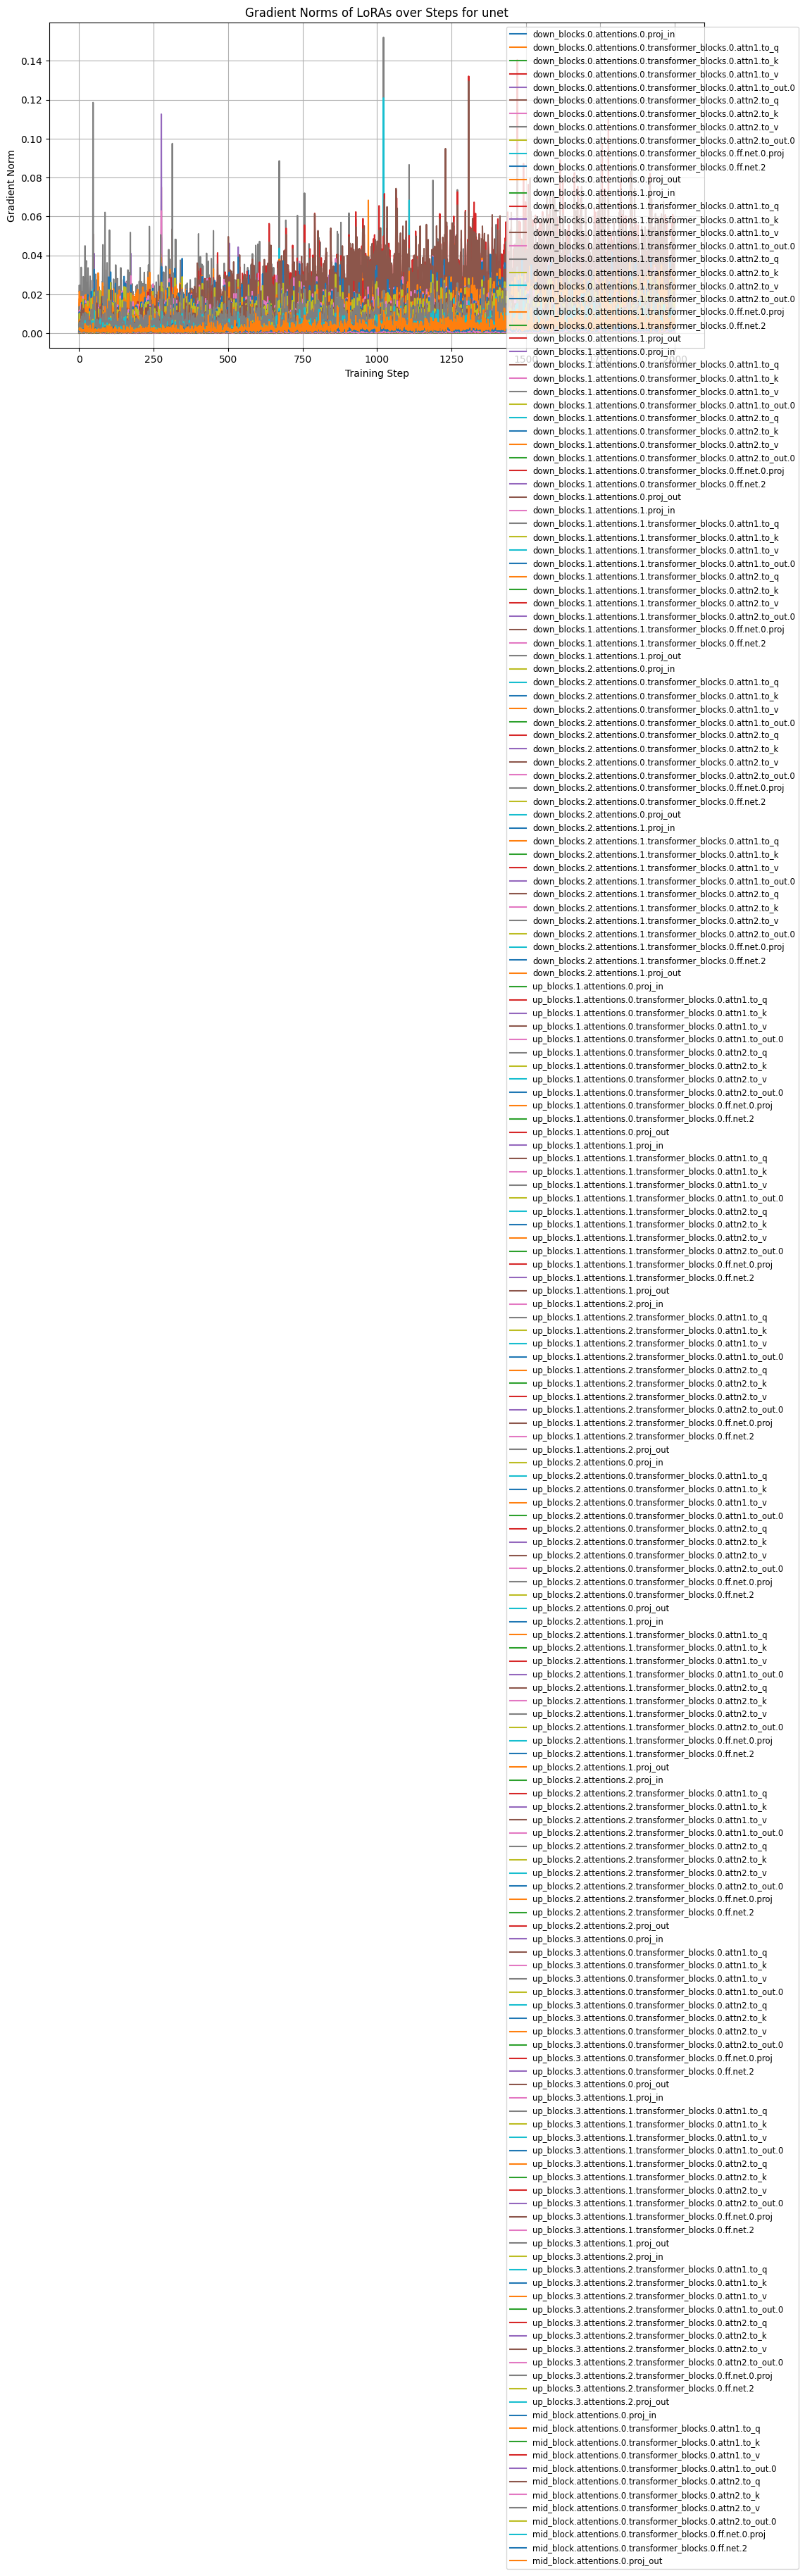

In [70]:
plot_unet_lora_grad_norms(tracked_lora_grads, steps, title="Gradient Norms of LoRAs over Steps for unet")

/tmp/ipython-input-67-928354771.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


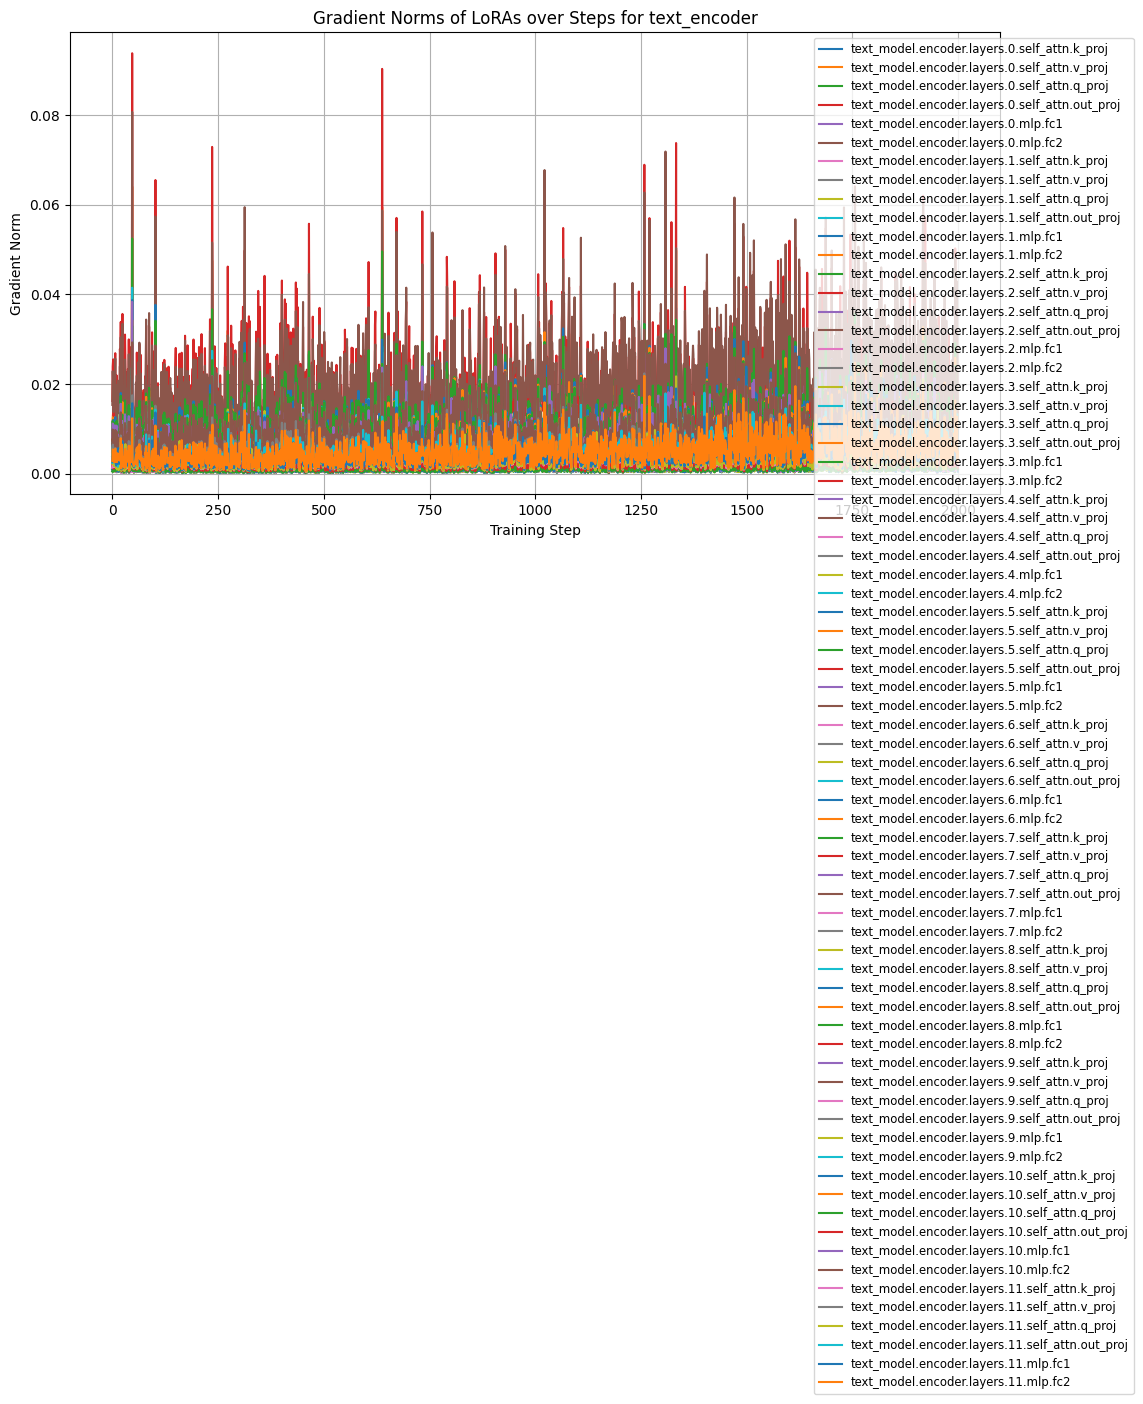

In [71]:
plot_text_encoder_lora_grad_norms(tracked_lora_grads, steps, title="Gradient Norms of LoRAs over Steps for text_encoder")

/tmp/ipython-input-68-1825413639.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


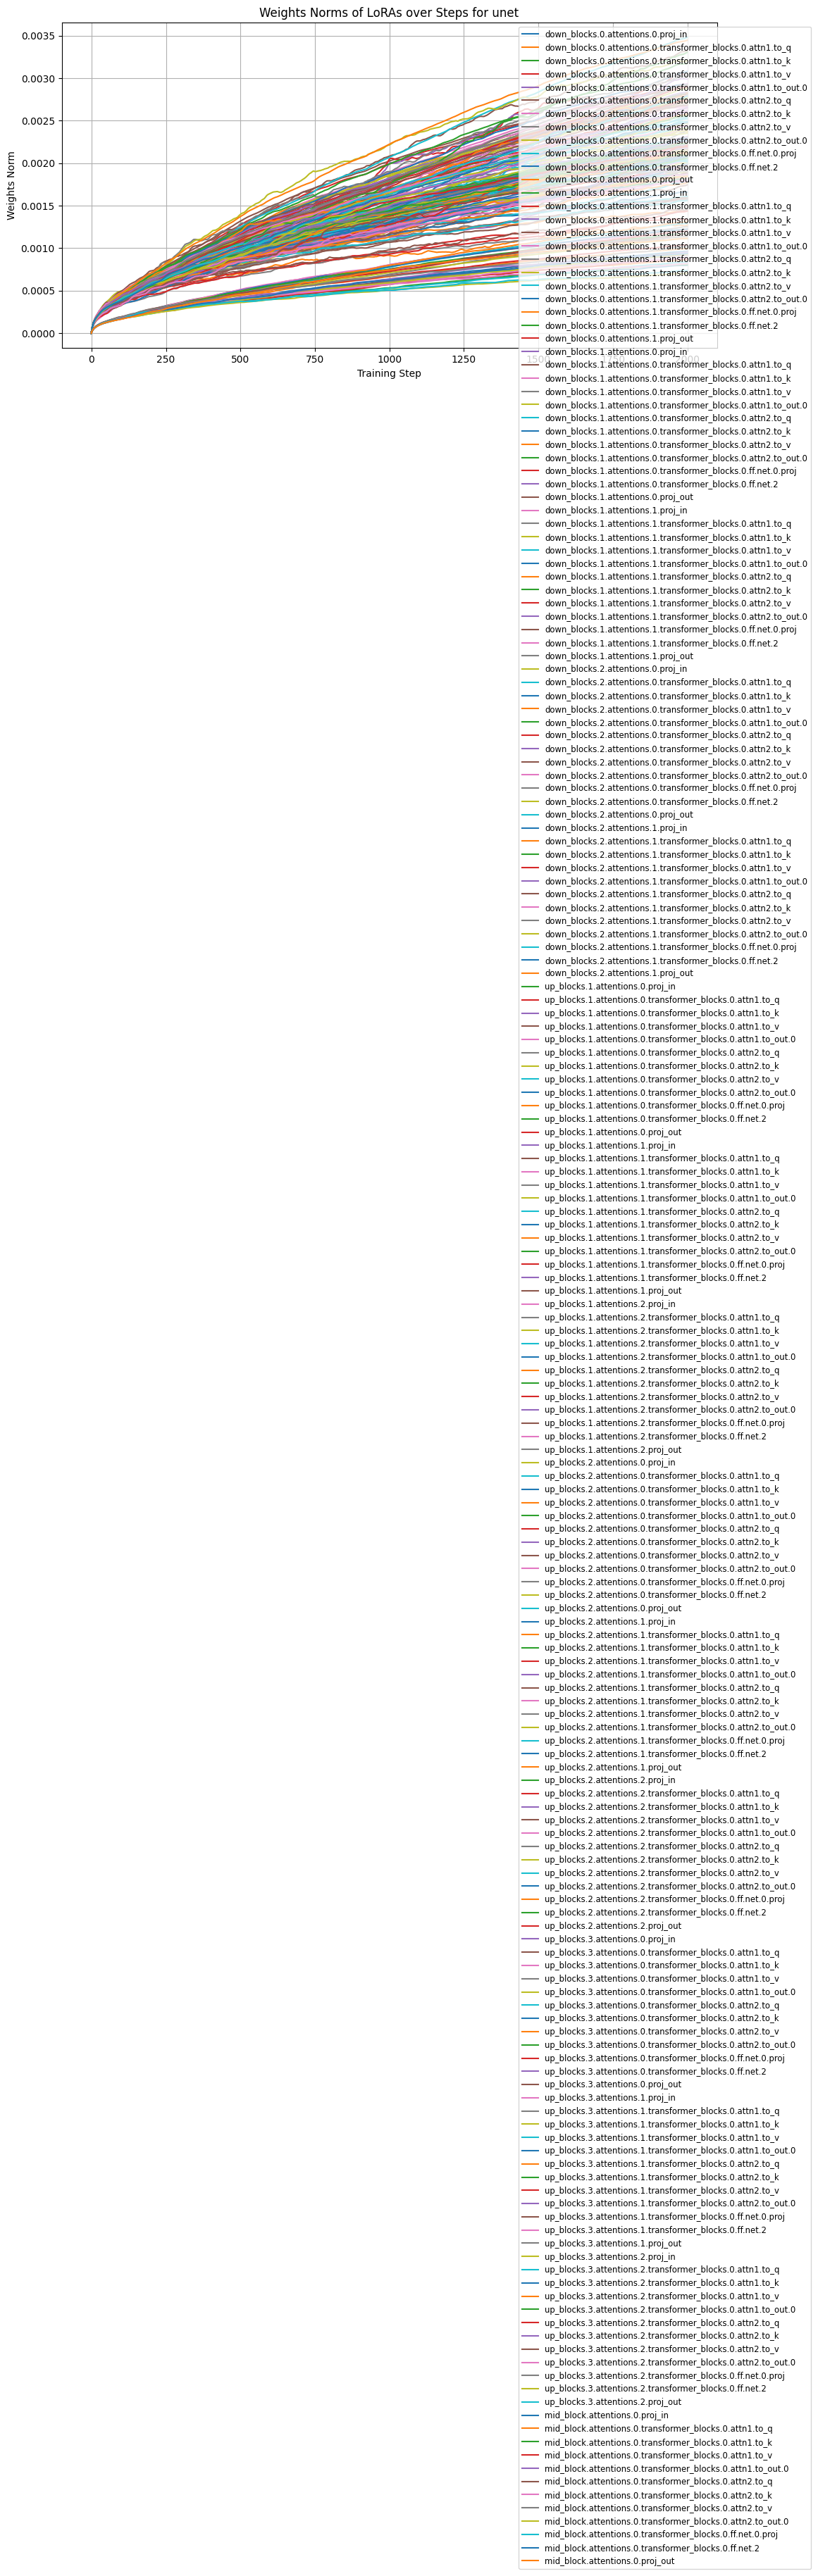

In [72]:
plot_unet_lora_weights(tracked_lora_weights, steps, title="Weights Norms of LoRAs over Steps for unet")

/tmp/ipython-input-69-1817679520.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


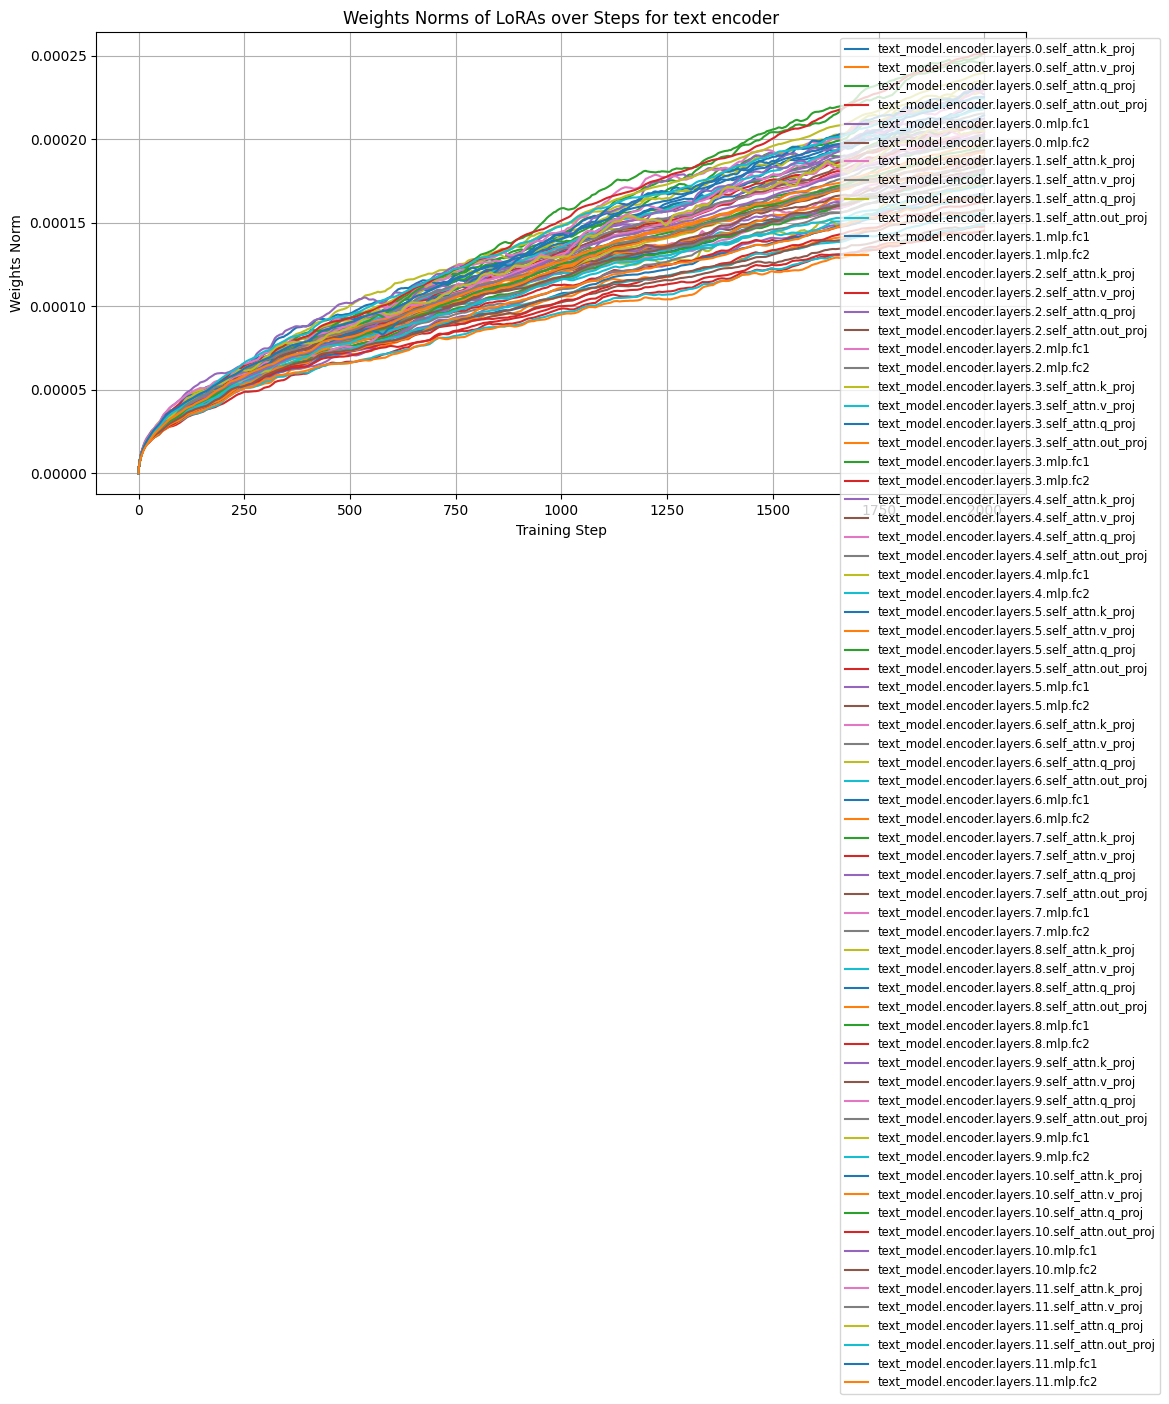

In [73]:
plot_text_encoder_lora_weights(tracked_lora_weights, steps, title="Weights Norms of LoRAs over Steps for text encoder")

/tmp/ipython-input-46-3117221964.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))


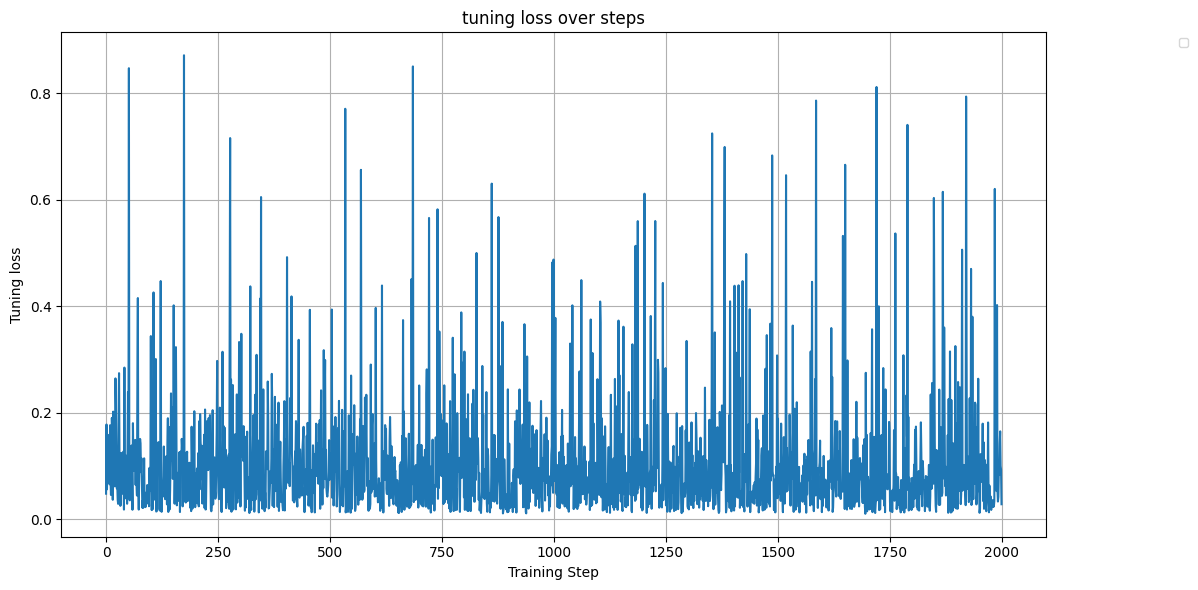

In [74]:
plot_tuning_loss(tuning_loss, steps, title="tuning loss over steps")

/tmp/ipython-input-47-943843772.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))


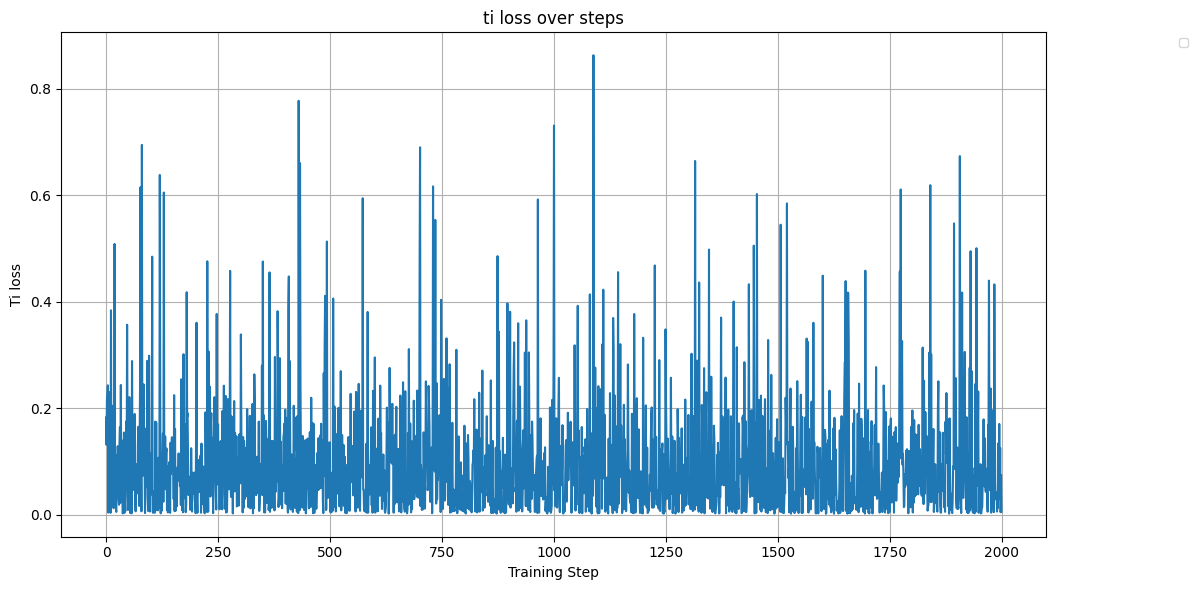

In [75]:
plot_ti_loss(ti_loss, steps, title="ti loss over steps")

/tmp/ipython-input-48-338905306.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small", bbox_to_anchor=(1.15, 1))


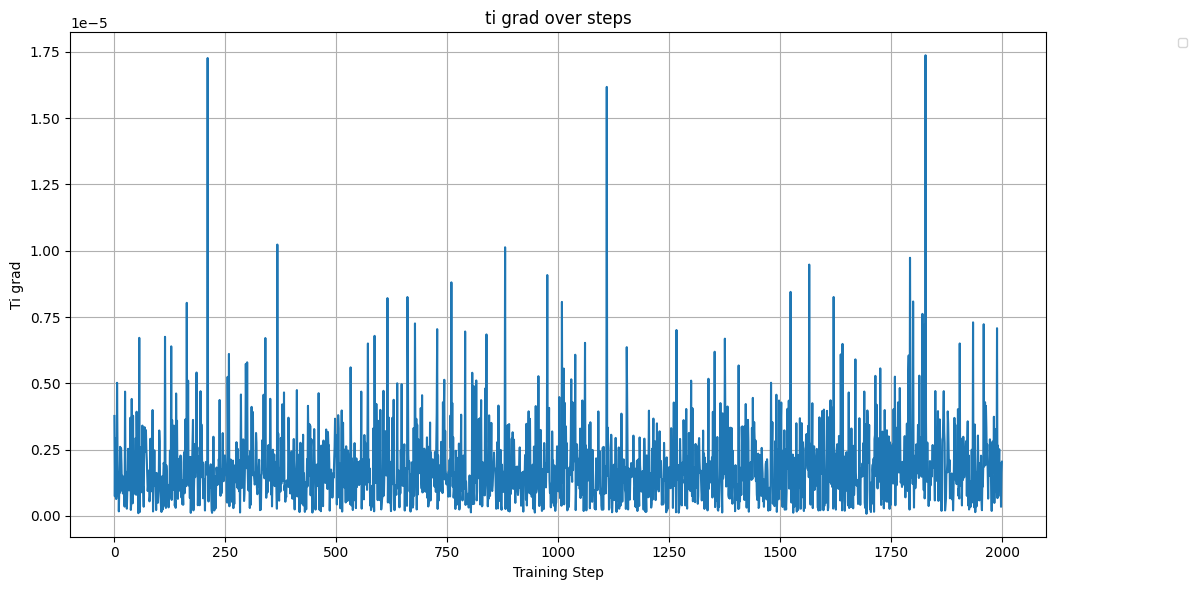

In [76]:
plot_ti_grad(ti_grad, steps, title="ti grad over steps")

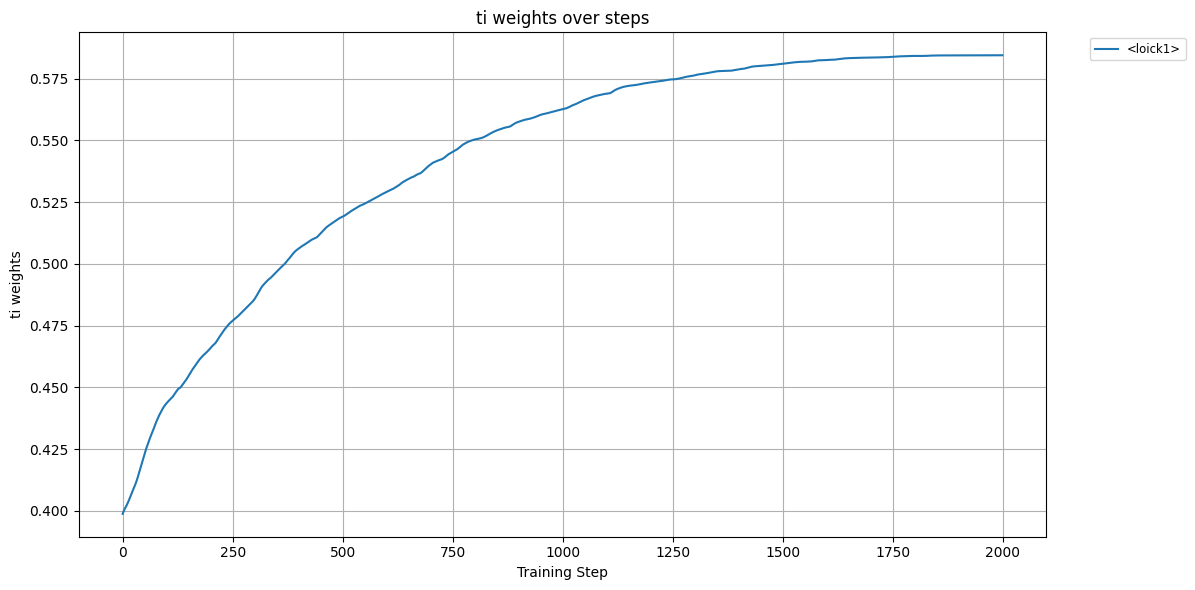

In [77]:
plot_ti_weights(ti_weights, steps, title="ti weights over steps")

In [78]:
print(tracked_lora_paths)

{'UNet2DConditionModel': ['down_blocks.0.attentions.0.proj_in', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v', 'down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0', 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q', 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k', 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_v', 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.0', 'down_blocks.0.attentions.0.transformer_blocks.0.ff.net.0.proj', 'down_blocks.0.attentions.0.transformer_blocks.0.ff.net.2', 'down_blocks.0.attentions.0.proj_out', 'down_blocks.0.attentions.1.proj_in', 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_q', 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_k', 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.to_v', 'down_blocks.0.attentions.1.transformer_bloc

In [79]:
print(tracked_lora_weights['down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q'][0])
print(tracked_lora_weights['down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q'][15])

0.0
0.00016404736379627138
